<a id='home'></a>
### Contents 

[Imports](#Imports)

[Data loading and processing](#Dataloadingandprocessing)

<a id='Imports'></a>
### Imports
[back to contents](#home)

In [2]:
%load_ext autoreload
%autoreload 2

In [86]:
import os
from os.path import join as p_join
import sys
import time
import itertools
from more_itertools import pairwise
from tqdm.notebook import tqdm
import pickle
import json
import joblib
import collections

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import clear_output, display
from warnings import filterwarnings
filterwarnings('ignore')

In [87]:
matplotlib.rcParams['figure.figsize'] = (8, 8)
sns.set_style('whitegrid')

---

In [5]:
!pip install -q lightfm==1.17
import lightfm
print(lightfm.__version__)

1.17


<a id='Dataloadingandprocessing'></a>
### Data loading and processing
[back to contents](#home)

In [6]:
DATA_PATH = '/content/drive/MyDrive/Data/mts_recsys_course'

In [8]:
df = pd.read_pickle(p_join(DATA_PATH, 'interactions_preprocessed.pickle'))
df_users = pd.read_pickle(p_join(DATA_PATH, 'users_preprocessed.pickle'))
df_items = pd.read_pickle(p_join(DATA_PATH, 'items_preprocessed.pickle'))

print(f"df: {df.shape[0]:,} x {df.shape[1]:,}")
display(df.head(3))
print(f"df_users: {df_users.shape[0]:,} x {df_users.shape[1]:,}")
display(df_users.head(3))
print(f"df_items: {df_items.shape[0]:,} x {df_items.shape[1]:,}")
display(df_items.head(3))

df: 1,532,998 x 5


,user_id,item_id,progress,rating,start_date
0,126706,14433,80,NaN,2018-01-01
1,127290,140952,58,NaN,2018-01-01
2,66991,198453,89,NaN,2018-01-01


df_users: 142,888 x 3


,user_id,age,sex
0,1,45_54,NaN
1,2,18_24,0.0
2,3,65_inf,0.0


df_items: 59,599 x 5


,id,title,genres,authors,year
0,128115,Ворон-челобитчик,"Зарубежные детские книги,Сказки,Зарубежная кла...",Михаил Салтыков-Щедрин,1886
1,210979,Скрипка Ротшильда,"Классическая проза,Литература 19 века,Русская ...",Антон Чехов,1894
2,95632,Испорченные дети,"Зарубежная классика,Классическая проза,Литерат...",Михаил Салтыков-Щедрин,1869


In [9]:
users_inv_mapping = dict(enumerate(df['user_id'].unique()))
users_mapping = {v: k for k, v in users_inv_mapping.items()}
print(len(users_mapping))

items_inv_mapping = dict(enumerate(df['item_id'].unique()))
items_mapping = {v: k for k, v in items_inv_mapping.items()}
print(len(items_mapping))

151600
59599


In [10]:
df_items['title'] = df_items['title'].str.lower()
item_titles = pd.Series(df_items['title'].values, index=df_items['id']).to_dict()
print(len(item_titles), item_titles[128115])
title_items = df_items.groupby('title')['id'].agg(list)
print(title_items)
title_count = title_items.map(len)
display(title_count.value_counts())

59599 ворон-челобитчик
title
# 20 восьмая                                                     [201623]
# duo                                                             [72582]
# me too. роман                                                  [171172]
# партия                                                         [224512]
#1917: человек из раньшего времени. библиотека «проекта 1917»    [230768]
                                                                   ...   
…чума на оба ваши дома!                                          [226481]
№ 12, или история одного прекрасного юноши                        [20979]
伦巴德人的故事                                                          [119226]
地球への旅                                                            [148400]
�baby blues�                                                      [98635]
Name: id, Length: 57289, dtype: object


1     55708
2      1197
3       245
4        71
5        38
6        11
7         8
8         3
9         2
18        1
11        1
13        1
23        1
12        1
47        1
Name: id, dtype: int64

In [11]:
df['rating'] = np.array(df['rating'].values, dtype=np.float32)

df.loc[df['item_id'].isin([44681, 162716])].groupby('item_id').agg({
    'progress': np.size,
    'rating': ['mean'],
    'start_date': ['min', 'max'],
})

progress rating start_date           
            size   mean        min        max
item_id                                      
44681        353   4.56 2018-01-24 2019-12-20
162716        59   4.80 2018-01-25 2019-12-30

<a id='LightFM'></a>
### LightFM
[back to contents](#home)

In [12]:
from lightfm.data import Dataset
from lightfm import LightFM

In [13]:
dataset = Dataset()
print(f"df['user_id'].unique(): {df['user_id'].unique().shape[0]:,}")
print(f"df['useitem_idr_id'].unique(): {df['item_id'].unique().shape[0]:,}")
dataset.fit(df['user_id'].unique(), df['item_id'].unique())

df['user_id'].unique(): 151,600
df['useitem_idr_id'].unique(): 59,599


In [14]:
df_users['age'] = df_users['age'].cat.add_categories('age_unknown')
df_users['age'] = df_users['age'].fillna('age_unknown')
age_features = df_users['age'].unique()
age_features

['45_54', '18_24', '65_inf', '35_44', '55_64', '25_34', 'age_unknown']
Categories (7, object): ['18_24', '25_34', '35_44', '45_54', '55_64', '65_inf', 'age_unknown']

In [15]:
df_users['sex'] = np.array(df_users['sex'].astype(str))
df_users['sex'] = df_users['sex'].fillna('age_unknown')
sex_features = df_users['sex'].unique()
sex_features

array(['nan', '0.0', '1.0'], dtype=object)

In [16]:
users_features = np.append(age_features, sex_features)
users_features

array(['45_54', '18_24', '65_inf', '35_44', '55_64', '25_34',
       'age_unknown', 'nan', '0.0', '1.0'], dtype=object)

In [17]:
dataset.fit_partial(user_features=users_features)

In [18]:
df_items['genres'] = df_items['genres'].cat.add_categories('genre_unknown')
df_items['genres'] = df_items['genres'].fillna('genre_unknown')
genres = list(df_items['genres'].str.split(',').explode().unique())
print(f"genres:")
print(genres[:15], '...')
len(genres)

genres:
['Зарубежные детские книги', 'Сказки', 'Зарубежная классика', 'Литература 19 века', 'Русская классика', 'Классическая проза', 'Пьесы и драматургия', 'Стихи и поэзия', 'Зарубежная старинная литература', 'Зарубежная драматургия', 'Античная литература', 'Литература 20 века', 'Детские стихи', 'Список школьной литературы 5-6 класс', 'Политология'] ...


641

In [19]:
dataset.fit_partial(item_features=genres)

In [20]:
num_users, num_items = dataset.interactions_shape()
print(f"{num_users:,}", f"{num_items:,}")

151,600 59,599


In [21]:
lightfm_mapping = dataset.mapping()
lightfm_mapping = {
    'users_mapping': lightfm_mapping[0],
    'user_features_mapping': lightfm_mapping[1],
    'items_mapping': lightfm_mapping[2],
    'item_features_mapping': lightfm_mapping[3],
}
print(f"users_mapping len - {len(lightfm_mapping['users_mapping']):,}")
print(f"user_features_mapping len - {len(lightfm_mapping['user_features_mapping']):,}")
print(f"items_mapping len - {len(lightfm_mapping['items_mapping']):,}")
print(f"Users item_features_mapping len - {len(lightfm_mapping['item_features_mapping']):,}")

lightfm_mapping['users_inv_mapping'] = {v: k for k, v in lightfm_mapping['users_mapping'].items()}
lightfm_mapping['items_inv_mapping'] = {v: k for k, v in lightfm_mapping['items_mapping'].items()}

users_mapping len - 151,600
user_features_mapping len - 151,610
items_mapping len - 59,599
Users item_features_mapping len - 60,240


In [22]:
set(lightfm_mapping['user_features_mapping']) - set(lightfm_mapping['users_mapping'])

{'0.0',
 '1.0',
 '18_24',
 '25_34',
 '35_44',
 '45_54',
 '55_64',
 '65_inf',
 'age_unknown',
 'nan'}

In [23]:
list(set(lightfm_mapping['item_features_mapping']) - set(lightfm_mapping['items_mapping']))[:15]

['Боевики',
 'Коммерческое право',
 'Бизнес-процессы',
 'Истории из жизни',
 'Семейная психология',
 'Социальная философия',
 'Зарубежная психология',
 'Современные любовные романы',
 'Книги о компьютерах',
 'Детективное фэнтези',
 'Естествознание',
 'Попаданцы',
 'Лояльность',
 'Руководства',
 'Клиентский сервис']

In [24]:
num_user_features = dataset.user_features_shape()
num_show_features = dataset.item_features_shape()
print(f'Num user features: {num_user_features[1] - num_users:,} -> {num_user_features[1]:,}\nnum item features: {num_show_features[1] - num_items:,} -> {num_show_features[1]:,}.')

Num user features: 10 -> 151,610
num item features: 641 -> 60,240.


We need 2 iterators to create dataset 
* For interecations we need iterator:
    * `[(user_id1, item_id1), (user_id2, item_id2), ...]`  
    * `[(user_id1, item_id1, weight), (user_id2, item_id2, weight), ...]`
* For features:
    * `[(id, [feature1, feature2, ...]), (id, [feature1, feature2, ...]), ...]`  
    * `[(id, {feature1: weight}), (id, {feature1: weight}), ...]`

In [25]:
# from typing import Iterator, Tuple

# def df_to_tuple_iterator(df: pd.DataFrame) -> Iterator:
#     return zip(*df.values.T)

# def concat_last_to_list(t: Tuple) -> Tuple:
#     return (t[0], list(t[1:])[0])

# def df_to_tuple_list_iterator(df: pd.DataFrame) -> Iterator:
#     return map(concat_last_to_list, zip(*df.values.T))

In [26]:
# class TimeRangeSplit():
#     """
#         https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.date_range.html
#     """
#     def __init__(self, 
#                  start_date, 
#                  end_date=None, 
#                  freq='D', 
#                  periods=None, 
#                  tz=None, 
#                  normalize=False, 
#                  closed=None, 
#                  train_min_date=None,
#                  filter_cold_users=True, 
#                  filter_cold_items=True, 
#                  filter_already_seen=True):
        
#         self.start_date = start_date
#         if end_date is None and periods is None:
#             raise ValueError("Either 'end_date' or 'periods' must be non-zero, not both at the same time.")

#         self.end_date = end_date
#         self.freq = freq
#         self.periods = periods
#         self.tz = tz
#         self.normalize = normalize
#         self.closed = closed
#         self.train_min_date = pd.to_datetime(train_min_date, errors='raise')
#         self.filter_cold_users = filter_cold_users
#         self.filter_cold_items = filter_cold_items
#         self.filter_already_seen = filter_already_seen

#         self.date_range = pd.date_range(
#             start=start_date, 
#             end=end_date, 
#             freq=freq, 
#             periods=periods, 
#             tz=tz, 
#             normalize=normalize, 
#             closed=closed)

#         self.max_n_splits = max(0, len(self.date_range) - 1)
#         if self.max_n_splits == 0:
#             raise ValueError("Provided parametrs set an empty date range.") 

#     def split(self, 
#               df, 
#               user_column='user_id',
#               item_column='item_id',
#               datetime_column='date',
#               fold_stats=False):
#         df_datetime = df[datetime_column]
#         if self.train_min_date is not None:
#             train_min_mask = df_datetime >= self.train_min_date
#         else:
#             train_min_mask = df_datetime.notnull()

#         date_range = self.date_range[(self.date_range >= df_datetime.min()) & 
#                                      (self.date_range <= df_datetime.max())]

#         for start, end in pairwise(date_range):
#             fold_info = {
#                 'Start date': start,
#                 'End date': end
#             }
#             train_mask = train_min_mask & (df_datetime < start)
#             train_idx = df.index[train_mask]
#             if fold_stats:
#                 fold_info['Train'] = len(train_idx)

#             test_mask = (df_datetime >= start) & (df_datetime < end)
#             test_idx = df.index[test_mask]
            
#             if self.filter_cold_users:
#                 new = np.setdiff1d(
#                     df.loc[test_idx, user_column].unique(), 
#                     df.loc[train_idx, user_column].unique())
#                 new_idx = df.index[test_mask & df[user_column].isin(new)]
#                 test_idx = np.setdiff1d(test_idx, new_idx)
#                 test_mask = df.index.isin(test_idx)
#                 if fold_stats:
#                     fold_info['New users'] = len(new)
#                     fold_info['New users interactions'] = len(new_idx)

#             if self.filter_cold_items:
#                 new = np.setdiff1d(
#                     df.loc[test_idx, item_column].unique(), 
#                     df.loc[train_idx, item_column].unique())
#                 new_idx = df.index[test_mask & df[item_column].isin(new)]
#                 test_idx = np.setdiff1d(test_idx, new_idx)
#                 test_mask = df.index.isin(test_idx)
#                 if fold_stats:
#                     fold_info['New items'] = len(new)
#                     fold_info['New items interactions'] = len(new_idx)

#             if self.filter_already_seen:
#                 user_item = [user_column, item_column]
#                 train_pairs = df.loc[train_idx, user_item].set_index(user_item).index
#                 test_pairs = df.loc[test_idx, user_item].set_index(user_item).index
#                 intersection = train_pairs.intersection(test_pairs)
#                 test_idx = test_idx[~test_pairs.isin(intersection)]
#                 # test_mask = rd.df.index.isin(test_idx)
#                 if fold_stats:
#                     fold_info['Known interactions'] = len(intersection)

#             if fold_stats:
#                 fold_info['Test'] = len(test_idx)

#             yield (train_idx, test_idx, fold_info)

#     def get_n_splits(self, df, datetime_column='date'):
#         df_datetime = df[datetime_column]
#         if self.train_min_date is not None:
#             df_datetime = df_datetime[df_datetime >= self.train_min_date]

#         date_range = self.date_range[(self.date_range >= df_datetime.min()) & 
#                                      (self.date_range <= df_datetime.max())]

#         return max(0, len(date_range) - 1)

In [27]:
# last_date = df['start_date'].max().normalize()
# folds = 7
# start_date = last_date - pd.Timedelta(days=folds)

# cv = TimeRangeSplit(start_date=start_date, periods=folds+1)

# cv.max_n_splits, cv.get_n_splits(df, datetime_column='start_date')

# folds_with_stats = list(cv.split(
#     df, 
#     user_column='user_id',
#     item_column='item_id',
#     datetime_column='start_date',
#     fold_stats=True
# ))

# folds_info_with_stats = pd.DataFrame([info for _, _, info in folds_with_stats])
# folds_info_with_stats

In [28]:
# train_idx, test_idx, info = folds_with_stats[0]

# train = df.loc[train_idx]
# test = df.loc[test_idx]

test_date_threshold = pd.Timestamp('2019-12-23')
last_test_date = pd.Timestamp('2019-12-24')
train = df.loc[(df['start_date'] <= test_date_threshold)].reset_index(drop=True)
test = df.loc[(df['start_date'] > test_date_threshold) & (df['start_date'] <= last_test_date)].reset_index(drop=True)
print(f"train: {train.shape[0]:,} (min/max dates: {train['start_date'].min().date()} - {train['start_date'].max().date()})")
display(train.head(3))
print(f"\ntest: {test.shape[0]:,} (min/max dates: {test['start_date'].min().date()} - {test['start_date'].max().date()})")
display(test.head(3))

train: 1,515,946 (min/max dates: 2018-01-01 - 2019-12-23)


,user_id,item_id,progress,rating,start_date
0,126706,14433,80,NaN,2018-01-01
1,127290,140952,58,NaN,2018-01-01
2,66991,198453,89,NaN,2018-01-01



test: 2,048 (min/max dates: 2019-12-24 - 2019-12-24)


,user_id,item_id,progress,rating,start_date
0,139942,26270,58,NaN,2019-12-24
1,136607,82392,39,NaN,2019-12-24
2,142287,84446,79,NaN,2019-12-24


In [37]:
train_mat, train_mat_weights = dataset.build_interactions(
    train[['user_id', 'item_id']].itertuples(index=False)
)
print(f"train_mat: {train_mat.shape[0]:,} x {train_mat.shape[1]:,} (n elements: {len(np.nonzero(train_mat)[0]):,})")
train_mat

train_mat: 151,600 x 59,599 (n elements: 1,515,946)


<151600x59599 sparse matrix of type '<class 'numpy.int32'>'
	with 1515946 stored elements in COOrdinate format>

In [38]:
df_users['features'] = df_users[['age', 'sex']].astype(str).apply(lambda x: list(x), axis=1)
df_users.head()

,user_id,age,sex,features
0,1,45_54,nan,"[45_54, nan]"
1,2,18_24,0.0,"[18_24, 0.0]"
2,3,65_inf,0.0,"[65_inf, 0.0]"
3,4,18_24,0.0,"[18_24, 0.0]"
4,5,35_44,0.0,"[35_44, 0.0]"


In [39]:
known_users_filter = df_users['user_id'].isin(df['user_id'].unique())
print(f"len(known_users_filter): {len(known_users_filter):,}")
train_user_features = dataset.build_user_features(
    df_users.loc[known_users_filter, ['user_id', 'features']].itertuples(index=False)   
)
print(f"train_user_features: {train_user_features.shape[0]:,} x {train_user_features.shape[1]:,}")
train_user_features

# known_users_filter = df_users['user_id'].isin(df['user_id'].unique())
# print(f"len(known_users_filter): {len(known_users_filter):,}")
# train_user_features = dataset.build_user_features(
#     df_to_tuple_list_iterator(
#         df_users.loc[known_users_filter, ['user_id', 'features']]
#     )
# )
# print(f"train_user_features: {train_user_features.shape[0]:,} x {train_user_features.shape[1]:,}")
# train_user_features

len(known_users_filter): 142,888
train_user_features: 151,600 x 151,610


<151600x151610 sparse matrix of type '<class 'numpy.float32'>'
	with 422954 stored elements in Compressed Sparse Row format>

In [40]:
df_items['features'] = df_items['genres'].str.split(',')
df_items.head()

,id,title,genres,authors,year,features
0,128115,ворон-челобитчик,"Зарубежные детские книги,Сказки,Зарубежная кла...",Михаил Салтыков-Щедрин,1886,"[Зарубежные детские книги, Сказки, Зарубежная ..."
1,210979,скрипка ротшильда,"Классическая проза,Литература 19 века,Русская ...",Антон Чехов,1894,"[Классическая проза, Литература 19 века, Русск..."
2,95632,испорченные дети,"Зарубежная классика,Классическая проза,Литерат...",Михаил Салтыков-Щедрин,1869,"[Зарубежная классика, Классическая проза, Лите..."
3,247906,странный человек,"Пьесы и драматургия,Литература 19 века",Михаил Лермонтов,1831,"[Пьесы и драматургия, Литература 19 века]"
4,294280,господа ташкентцы,"Зарубежная классика,Классическая проза,Литерат...",Михаил Салтыков-Щедрин,1873,"[Зарубежная классика, Классическая проза, Лите..."


In [41]:
known_items_filter = df_items['id'].isin(df['item_id'].unique())
train_items_features = dataset.build_item_features(
    df_items.loc[known_items_filter, ['id', 'features']].itertuples(index=False)
)
print(f"train_items_features: {train_items_features.shape[0]:,} x {train_items_features.shape[1]:,}")
train_items_features

# known_items_filter = df_items['id'].isin(df['item_id'].unique())
# train_items_features = dataset.build_item_features(
#     df_to_tuple_list_iterator(
#         df_items.loc[known_items_filter, ['id', 'features']]
#     )
# )
# print(f"train_items_features: {train_items_features.shape[0]:,} x {train_items_features.shape[1]:,}")
# train_items_features

train_items_features: 59,599 x 60,240


<59599x60240 sparse matrix of type '<class 'numpy.float32'>'
	with 186360 stored elements in Compressed Sparse Row format>

In [42]:
from tqdm import tqdm

lfm_model = LightFM(
    no_components=64, 
    learning_rate=0.05, 
    loss='warp', 
    max_sampled=5, 
    random_state=23
)

num_epochs = 15
for _ in tqdm(range(num_epochs), total=num_epochs):
    lfm_model.fit_partial(
        train_mat, 
        user_features=train_user_features,
        item_features=train_items_features,
        num_threads=2
    )

100%|██████████| 15/15 [05:40<00:00, 22.72s/it]


In [43]:
print(f"user_embeddings: {lfm_model.user_embeddings.shape[0]:,} x {lfm_model.user_embeddings.shape[1]:,}")
print(f"user_biases: {lfm_model.user_biases.shape[0]:,}")
print(f"item_embeddings: {lfm_model.item_embeddings.shape[0]:,} x {lfm_model.item_embeddings.shape[1]:,}")
print(f"item_biases: {lfm_model.item_biases.shape[0]:,}")

user_embeddings: 151,610 x 64
user_biases: 151,610
item_embeddings: 60,240 x 64
item_biases: 60,240


In [84]:
%%time
from sklearn.manifold import TSNE

N = 5_000
users_subsample_idxs = np.random.choice(np.arange(len(lightfm_mapping['users_mapping'])), size=N)
user_embs_tsne = (
    TSNE(n_components=2)
    .fit_transform(
        lfm_model.user_embeddings[users_subsample_idxs]
    )
)
print(f"user_embs_tsne: {user_embs_tsne.shape[0]:,} x {user_embs_tsne.shape[1]:,}")

user_embs_tsne: 5,000 x 2
CPU times: user 1min 55s, sys: 383 ms, total: 1min 56s
Wall time: 2min 28s


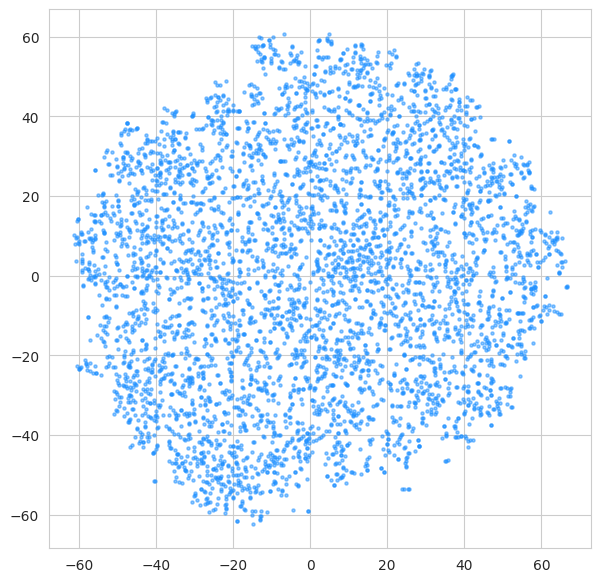

In [88]:
plt.figure(figsize=(7, 7))
plt.scatter(
    user_embs_tsne[:, 0],
    user_embs_tsne[:, 1],
    color='dodgerblue',
    s=5,
    alpha=0.5,
)

In [44]:
len(items_inv_mapping), len(items_mapping)

(59599, 59599)

In [121]:
# recommendations by method
np.random.seed(12432)
n_recommendations = 10
random_user_id = test['user_id'].sample().item()
print(f"random_user_id: {random_user_id}")
pred = lfm_model.predict(
    user_ids=lightfm_mapping['users_mapping'][random_user_id] , 
    item_ids=np.arange(len(lightfm_mapping['items_mapping'])), 
    user_features=train_user_features, 
    item_features=train_items_features, 
    num_threads=2,
)
print(f"pred: {pred.shape}")
pred

random_user_id: 107082
pred: (59599,)


array([-108.932526, -111.22778 , -110.73593 , ..., -109.75919 ,
       -109.70975 , -106.18867 ], dtype=float32)

In [122]:
top_cols = np.argpartition(pred, -np.arange(n_recommendations))[-n_recommendations:][::-1]
print(top_cols)
recommended_items = [lightfm_mapping['items_inv_mapping'][item_id] for item_id in top_cols]
print(recommended_items)
recommended_items_with_info = (
    df_items
    .set_index('id')
    .loc[recommended_items]
    [['title', 'genres', 'authors', 'year']]
)
display(recommended_items_with_info)

[ 8618 21299  5700 35688  2177  1290 34023 35339 18126 37955]
[104868, 251645, 62381, 115706, 310684, 316942, 231664, 226402, 148327, 36932]


,title,genres,authors,year
id,,,,
104868,"разведенная жена, или жизнь после","Эротические романы,Остросюжетные любовные рома...",Дарья Кова,2017
251645,земное притяжение,"Современные детективы,Остросюжетные любовные р...",Татьяна Устинова,2017
62381,один год жизни,"Остросюжетные любовные романы,Современные любо...",Anne Dar,2017
115706,чудовищное предложение,"Эротические романы,Остросюжетные любовные рома...",Стелла Грей,2019
310684,селфи с судьбой,"Современные детективы,Остросюжетные любовные р...",Татьяна Устинова,2017
316942,судьба-волшебница,"Современные детективы,Остросюжетные любовные р...",Татьяна Полякова,2016
231664,белоснежный роман,"Остросюжетные любовные романы,Современные любо...",Татьяна Алюшина,2018
226402,соблазни меня нежно,"Эротические романы,Остросюжетные любовные рома...",Дарья Кова,2018
148327,леди и бродяга,"Эротические романы,Остросюжетные любовные рома...",Эмилия Грин,2019


In [127]:
# manual recommendations (by dot product)
np.random.seed(12432)
n_recommendations = 10
random_user_id = test['user_id'].sample().item()
print(f"random_user_id: {random_user_id}")
preds = (
    lfm_model.user_embeddings[random_user_id] @ lfm_model.item_embeddings.T 
    + lfm_model.item_biases
)
print(f"pred: {pred.shape}")
pred

random_user_id: 107082
pred: (59599,)


array([-108.932526, -111.22778 , -110.73593 , ..., -109.75919 ,
       -109.70975 , -106.18867 ], dtype=float32)

In [128]:
top_cols = np.argpartition(pred, -np.arange(n_recommendations))[-n_recommendations:][::-1]
print(top_cols)
recommended_items = [lightfm_mapping['items_inv_mapping'][item_id] for item_id in top_cols]
print(recommended_items)
recommended_items_with_info = (
    df_items
    .set_index('id')
    .loc[recommended_items]
    [['title', 'genres', 'authors', 'year']]
)
display(recommended_items_with_info)

[ 8618 21299  5700 35688  2177  1290 34023 35339 18126 37955]
[104868, 251645, 62381, 115706, 310684, 316942, 231664, 226402, 148327, 36932]


,title,genres,authors,year
id,,,,
104868,"разведенная жена, или жизнь после","Эротические романы,Остросюжетные любовные рома...",Дарья Кова,2017
251645,земное притяжение,"Современные детективы,Остросюжетные любовные р...",Татьяна Устинова,2017
62381,один год жизни,"Остросюжетные любовные романы,Современные любо...",Anne Dar,2017
115706,чудовищное предложение,"Эротические романы,Остросюжетные любовные рома...",Стелла Грей,2019
310684,селфи с судьбой,"Современные детективы,Остросюжетные любовные р...",Татьяна Устинова,2017
316942,судьба-волшебница,"Современные детективы,Остросюжетные любовные р...",Татьяна Полякова,2016
231664,белоснежный роман,"Остросюжетные любовные романы,Современные любо...",Татьяна Алюшина,2018
226402,соблазни меня нежно,"Эротические романы,Остросюжетные любовные рома...",Дарья Кова,2018
148327,леди и бродяга,"Эротические романы,Остросюжетные любовные рома...",Эмилия Грин,2019
